# Salt Fluxes

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.colors as colors
import seaborn as sns
import seaborn
import pandas as pd
import numpy as np
from importlib import reload
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw
import scipy.ndimage as filter
import scipy.interpolate as interpolate
from flox.xarray import xarray_reduce
from xgcm.autogenerate import generate_grid_ds
from xgcm import Grid

In [2]:
import os
os.chdir('/home.ufs/amf2288/argo-intern/funcs')
import filt_funcs as ff

In [3]:
# Set title size
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 16  # Titles larger

# Set axis label size
plt.rcParams['axes.labelsize'] = 14  # Labels slightly smaller

## Functions

In [4]:
def interp_to_rho(rho_profile, var_profile, rho_grid, flag='group'):
    
    valid = ~np.isnan(rho_profile) & ~np.isnan(var_profile)
    rho_nonan = rho_profile[valid]
    var_nonan = var_profile[valid]

    if len(rho_nonan) < 3 or len(var_nonan) < 3:
        return np.full_like(rho_grid, np.nan)

    if flag == 'group':
        _, idx = np.unique(rho_nonan, return_index=True)
        rho_nonan = rho_nonan[idx]
        var_nonan = var_nonan[idx]

    fvar = interpolate.PchipInterpolator(rho_nonan, var_nonan, extrapolate=False)
    return fvar(rho_grid)

In [5]:
def get_ds_rho(ds_z, da_SIG0, rho_grid, variables, dim1='N_PROF', dim2='PRES_INTERPOLATED'):

    xrs = []
    rho_size = rho_grid.size
    
    for var in variables:
        var_interp = xr.apply_ufunc(interp_to_rho, da_SIG0, ds_z[var],
            input_core_dims=[['PRES_INTERPOLATED'], ['PRES_INTERPOLATED']],
            output_core_dims=[['rho_grid']],
            dask_gufunc_kwargs={'output_sizes': {'rho_grid': rho_size}},
            vectorize=True,
            dask='parallelized',
            kwargs={'rho_grid': rho_grid},
            output_dtypes=[ds_z[var].dtype])
        print(f'Completed comp for {var}')
        var_interp = xr.DataArray(
            data=var_interp.data,
            dims=['N_PROF', 'rho_grid'],
            coords={'rho_grid': rho_grid, 'N_PROF': ds_z.N_PROF},
            name=var)
        xrs.append(var_interp)
        print(f'Completed {var}')
    
    ds_rho = xr.merge(xrs)
    print(f'Completed merge')
    #ds_rho = ds_rho.assign_coords(TIME      =(dim1, ds_z.TIME.data))
    ds_rho = ds_rho.assign_coords(LATITUDE  =(dim1, ds_z.LATITUDE.data))
    ds_rho = ds_rho.assign_coords(LONGITUDE =(dim1, ds_z.LONGITUDE.data))
    
    return ds_rho

In [6]:
def get_ds_gridded(ds, lon_bins, lat_bins):
    # Step 1: Reduce using flox
    ds_binned = xarray_reduce(
        ds,
        'LONGITUDE',
        'LATITUDE',
        func='mean',
        expected_groups=(
            pd.IntervalIndex.from_breaks(lon_bins),
            pd.IntervalIndex.from_breaks(lat_bins)
        ),
        fill_value=np.nan,
        skipna=True
    )

    # Step 2: Rename dimensions and variables
    ds_binned = ds_binned.rename_dims({
        'LONGITUDE_bins': 'lon',
        'LATITUDE_bins': 'lat',
        'rho_grid': 'density'
    }).rename_vars({
        'LONGITUDE_bins': 'lon',
        'LATITUDE_bins': 'lat',
        'rho_grid': 'density'
    })

    # Step 3: Replace Interval coordinates with midpoints
    def interval_midpoints(intervals):
        return np.array([interval.mid for interval in intervals])

    ds_binned = ds_binned.assign_coords({
        'lon': ('lon', interval_midpoints(ds_binned['lon'].values)),
        'lat': ('lat', interval_midpoints(ds_binned['lat'].values))
    })

    # Step 4: Generate grid and xgcm object
    ds_gridded = generate_grid_ds(ds_binned, {'X': 'lon', 'Y': 'lat'})
    grid = Grid(ds_gridded, coords={
        'X': {'center': 'lon', 'left': 'lon_left'},
        'Y': {'center': 'lat', 'left': 'lat_left'},
        'Z': {'center': 'density'}
    }, periodic=['X'])

    return ds_gridded, grid

In [7]:
def get_grad(ds_gridded, grid, var):
    dlong = grid.diff(ds_gridded.lon, 'X')
    dlatg = grid.diff(ds_gridded.lat, 'Y', boundary='fill', fill_value=np.nan)
    
    distance_1deg_equator = 111000
    dx = dlong * np.cos(np.deg2rad(ds_gridded.lat)) * distance_1deg_equator
    dy = ((ds_gridded.lon * 0) + 1) * dlatg * distance_1deg_equator
    
    dC_dx = grid.diff(ds_gridded[var], 'X') / dx
    dC_dy = grid.diff(ds_gridded[var], 'Y') / dy
    
    dC_dx = grid.interp(dC_dx, ['X'], to='center')
    dC_dy = grid.interp(dC_dy, ['Y'], to='center')
    
    return dC_dx, dC_dy

## Term (1)

In [8]:
diff_rho = xr.open_dataset('/swot/SUM05/amf2288/diff_rho_3.nc')
K_rho = diff_rho.K_rho

In [9]:
K_rho = K_rho.rename({'rho_grid':'density','lat_c':'lat','lon_c':'lon'})

## Term (2)

In [10]:
lfilt = 100
rho_grid = np.arange(21,29,0.0025)
lon_bins = np.arange(-180,181,3)
lat_bins = np.arange(-67.5,68,3)

In [11]:
ds = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_high_res_1.nc')

In [12]:
sa_e = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/sa_e_3.nc', chunks={'N_PROF':100000})

In [13]:
sa_e_z2 = sa_e.differentiate(coord='PRES_INTERPOLATED')**2

In [14]:
%%time
sa_e_z2_filt = ff.da_filt_single(sa_e_z2, lfilt)

CPU times: user 1min 49s, sys: 54.9 s, total: 2min 43s
Wall time: 2min 21s


In [15]:
sa_e_z2_filt.name = 'sa_e_z2_filt'
sa_e_z2_filt = sa_e_z2_filt.to_dataset()

In [16]:
%%time
sa_e_z2_filt_rho = get_ds_rho(sa_e_z2_filt.chunk({'N_PROF':100000}), ds.SIG0, rho_grid, variables=['sa_e_z2_filt'])

Completed comp for sa_e_z2_filt
Completed sa_e_z2_filt
Completed merge
CPU times: user 35.2 s, sys: 20.9 s, total: 56.1 s
Wall time: 57.5 s


In [17]:
sa_e_z2_filt_rho

<xarray.Dataset> Size: 38GB
Dimensions:       (rho_grid: 3200, N_PROF: 1488063)
Coordinates:
  * rho_grid      (rho_grid) float64 26kB 21.0 21.0 21.01 ... 28.99 29.0 29.0
  * N_PROF        (N_PROF) int64 12MB 2428701 1114461 2155018 ... 1502504 411205
    LATITUDE      (N_PROF) float64 12MB dask.array<chunksize=(100000,), meta=np.ndarray>
    LONGITUDE     (N_PROF) float64 12MB dask.array<chunksize=(100000,), meta=np.ndarray>
Data variables:
    sa_e_z2_filt  (N_PROF, rho_grid) float64 38GB dask.array<chunksize=(16760, 3200), meta=np.ndarray>

In [26]:
%%time
term2, term2_grid = get_ds_gridded(sa_e_z2_filt_rho, lon_bins, lat_bins)

CPU times: user 50.8 ms, sys: 7.47 ms, total: 58.3 ms
Wall time: 55.8 ms


In [ ]:
%%time
term2.to_netcdf('/swot/SUM05/amf2288/var-boxes/term2_sa.nc')

## Term (3)

In [12]:
sa_m = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/sa_m_3.nc', chunks={'N_PROF':100000})

In [13]:
sa_m.name = 'sa_m'
sa_m = sa_m.to_dataset()

In [14]:
%%time
sa_m_rho = get_ds_rho(sa_m, ds.SIG0, rho_grid, variables=['sa_m'])

Completed comp for sa_m
Completed sa_m
Completed merge
CPU times: user 20.4 s, sys: 17.3 s, total: 37.6 s
Wall time: 37.6 s


In [15]:
%%time
sa_m_rho_gridded, sa_m_rho_grid = get_ds_gridded(sa_m_rho, lon_bins, lat_bins)

CPU times: user 46.8 ms, sys: 11.8 ms, total: 58.6 ms
Wall time: 55.9 ms


In [16]:
sa_m_dx, sa_m_dy = get_grad(sa_m_rho_gridded, sa_m_rho_grid, 'sa_m')

/home.ufs/amf2288/miniforge3/envs/Argo_Feb_25/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home.ufs/amf2288/miniforge3/envs/Argo_Feb_25/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home.ufs/amf2288/miniforge3/envs/Argo_Feb_25/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will b

In [17]:
%%time
sa_m_dx.to_netcdf('/swot/SUM05/amf2288/var-boxes/sa_m_dx.nc')
sa_m_dy.to_netcdf('/swot/SUM05/amf2288/var-boxes/sa_m_dy.nc')

CPU times: user 1h 28min 39s, sys: 50min 7s, total: 2h 18min 47s
Wall time: 1h 8min 30s


In [18]:
term3 = np.sqrt(sa_m_dx**2 + sa_m_dy**2)

In [19]:
term3.to_netcdf('/swot/SUM05/amf2288/var-boxes/term3_sa.nc')

## Plots

In [21]:
ds_rho = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_rho_binned_high_res.nc')

In [22]:
%%time
term2_ds = xr.open_dataset('/swot/SUM05/amf2288/var-boxes/term2_sa.nc').load()
term2 = term2_ds.sa_e_z2_filt.rename('term2')
term3 = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/term3_sa.nc').rename('term3').load()
sa_m_dx = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/sa_m_dx.nc')
sa_m_dy = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/sa_m_dy.nc')

CPU times: user 0 ns, sys: 325 ms, total: 325 ms
Wall time: 323 ms


In [24]:
%%time
salt_flux_dxdy = K_rho*(term2/term3)

CPU times: user 75.5 ms, sys: 351 ms, total: 426 ms
Wall time: 424 ms


In [103]:
K_e_salt = K_rho*(term2/term3**2)

In [25]:
salt_flux_dxdy.to_netcdf('/swot/SUM05/amf2288/var-boxes/salt_flux_dxdy.nc')

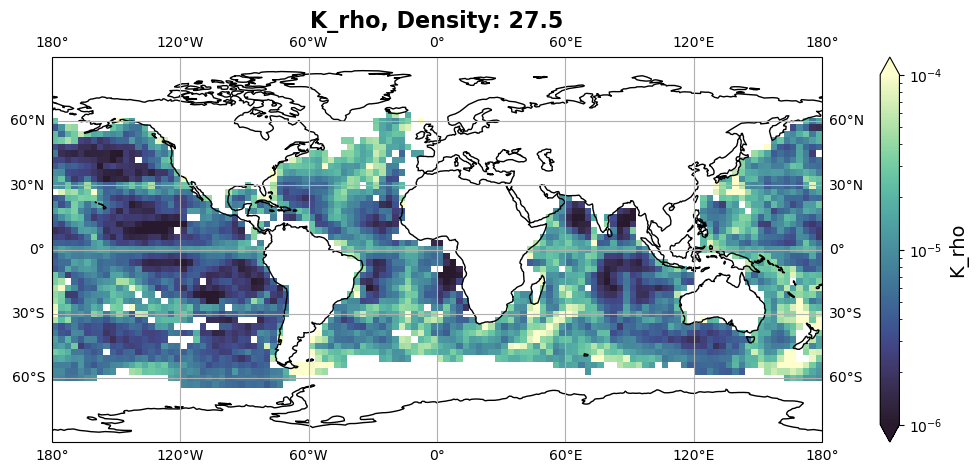

In [30]:
density = 27.5

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
K_rho.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.deep_r, norm=colors.LogNorm(vmin=1e-6, vmax=1e-4))
ax.set_title('K_rho, Density: {}'.format(np.round(term2.sel(density=density, method='nearest').density.values, 1)))
plt.savefig('../notebooks/argo_clim/figs/K_rho_275.png', bbox_inches='tight')

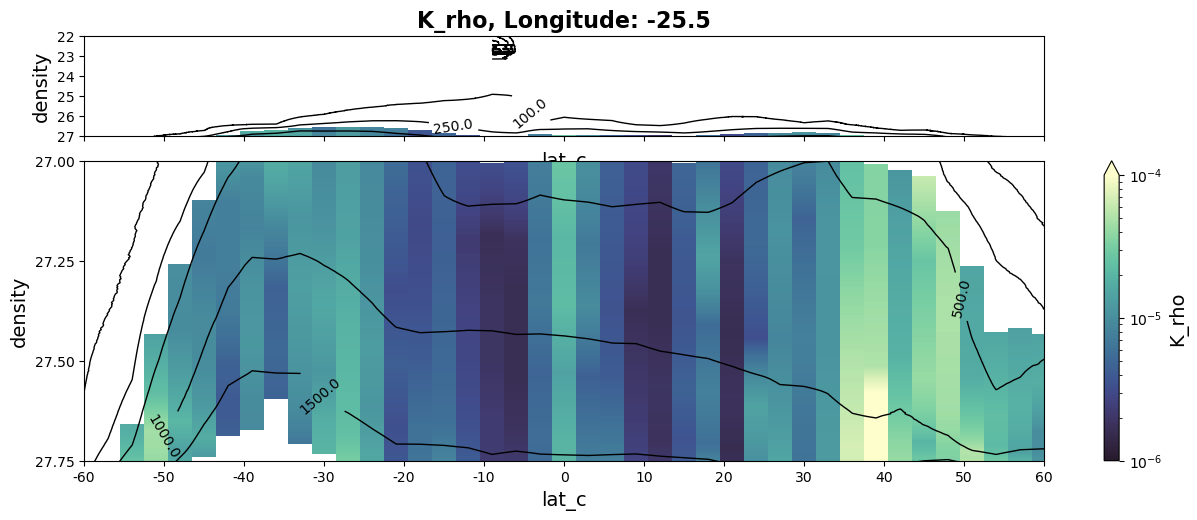

In [31]:
lon = -25

fig = plt.figure(figsize=(15, 5))
top_ax = fig.add_axes([0.1, 0.75, 0.64, 0.2])   # top subplot (1/4 of height)
bottom_ax = fig.add_axes([0.1, 0.1, 0.8, 0.6]) # bottom subplot (3/4 of height)

norm = colors.LogNorm(vmin=1e-6, vmax=1e-4)
levels = [100, 250, 500, 1000, 1500, 2000]

K_rho.sel(lon=lon, method='nearest').plot(ax=top_ax, x='lat', y='density', cmap=cmo.deep_r, norm=norm, add_colorbar=False)
top_ax.set_xticks(np.arange(-70, 71, 10))
top_ax.set_xticklabels([''] * len(top_ax.get_xticks()))
top_ax.set_yticks(np.arange(27.0, 21.5, -1.0))
top_ax.set_xlabel('')
top_ax.set_ylim(27, 22)
top_ax.set_xlim(-60, 60)
contour = ds_rho.PRES.sel(lon_c=lon, method='nearest').plot.contour(ax=top_ax, x='lat_c', y='density', levels=levels, colors='k', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='k', fontsize=10)
top_ax.invert_yaxis()
top_ax.set_title(f'K_rho, Longitude: {K_rho.sel(lon=lon, method="nearest").lon.values}')

K_rho.sel(lon=lon, method='nearest').plot(ax=bottom_ax, x='lat', y='density', cmap=cmo.deep_r, norm=norm)
bottom_ax.set_xticks(np.arange(-70, 71, 10))
bottom_ax.set_xticklabels(np.arange(-70, 71, 10))
bottom_ax.set_yticks(np.arange(27.75, 25.5, -0.25))
bottom_ax.set_ylim(27.75, 27)
bottom_ax.set_xlim(-60, 60)
contour = ds_rho.PRES.sel(lon_c=lon, method='nearest').plot.contour(ax=bottom_ax, x='lat_c', y='density', levels=levels, colors='k', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='k', fontsize=10)
bottom_ax.invert_yaxis()
bottom_ax.set_title('')

plt.savefig('../notebooks/argo_clim/figs/K_rho_275_sect.png', bbox_inches='tight')

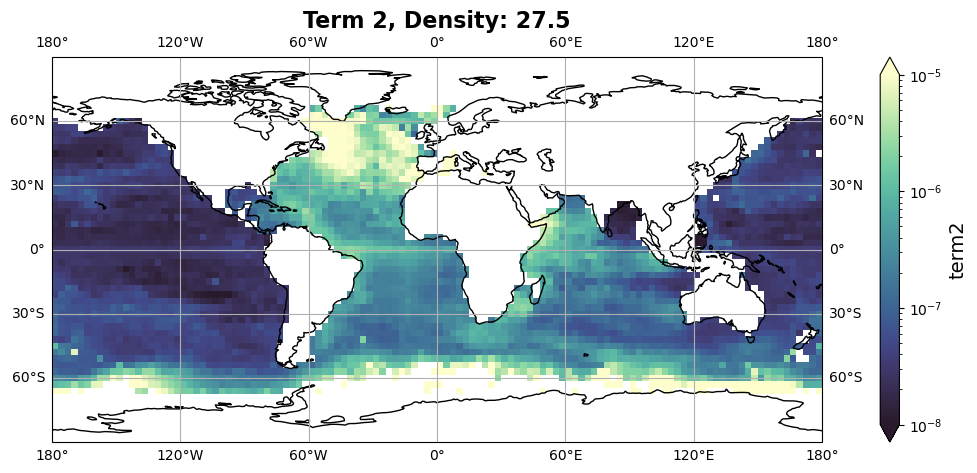

In [34]:
density = 27.5

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
term2.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.deep_r, norm=colors.LogNorm(vmin=1e-8, vmax=1e-5))
ax.set_title('Term 2, Density: {}'.format(np.round(term2.sel(density=density, method='nearest').density.values, 1)))
plt.savefig('../notebooks/argo_clim/figs/term2_sa_275.png', bbox_inches='tight')

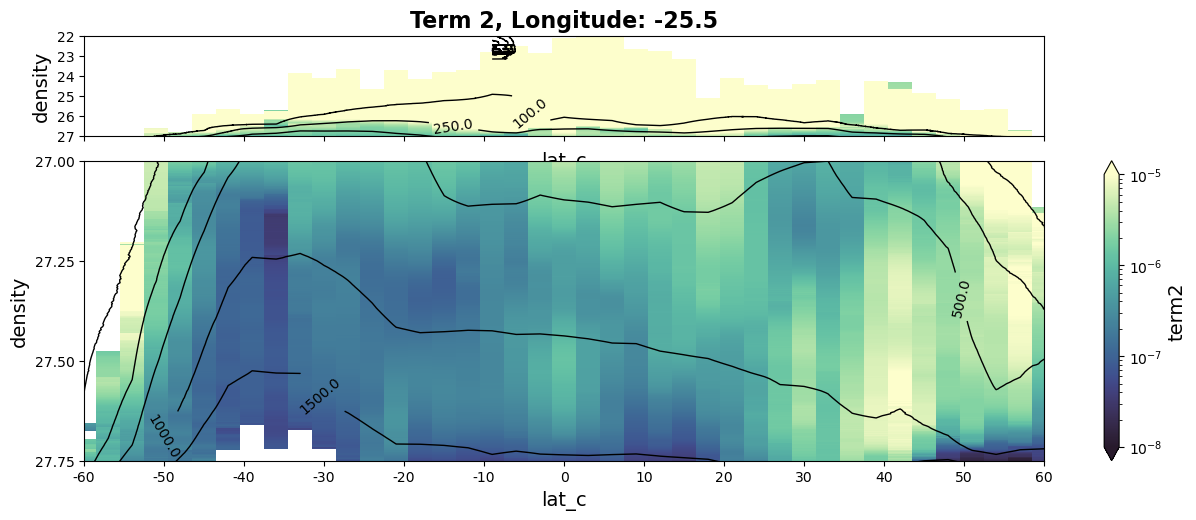

In [35]:
lon = -25

fig = plt.figure(figsize=(15, 5))
top_ax = fig.add_axes([0.1, 0.75, 0.64, 0.2])   # top subplot (1/4 of height)
bottom_ax = fig.add_axes([0.1, 0.1, 0.8, 0.6]) # bottom subplot (3/4 of height)

norm = colors.LogNorm(vmin=1e-8, vmax=1e-5)
levels = [100, 250, 500, 1000, 1500, 2000]

term2.sel(lon=lon, method='nearest').plot(ax=top_ax, x='lat', y='density', cmap=cmo.deep_r, norm=norm, add_colorbar=False)
top_ax.set_xticks(np.arange(-70, 71, 10))
top_ax.set_xticklabels([''] * len(top_ax.get_xticks()))
top_ax.set_yticks(np.arange(27.0, 21.5, -1.0))
top_ax.set_xlabel('')
top_ax.set_ylim(27, 22)
top_ax.set_xlim(-60, 60)
contour = ds_rho.PRES.sel(lon_c=lon, method='nearest').plot.contour(ax=top_ax, x='lat_c', y='density', levels=levels, colors='k', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='k', fontsize=10)
top_ax.invert_yaxis()
top_ax.set_title(f'Term 2, Longitude: {K_rho.sel(lon=lon, method="nearest").lon.values}')

term2.sel(lon=lon, method='nearest').plot(ax=bottom_ax, x='lat', y='density', cmap=cmo.deep_r, norm=norm)
bottom_ax.set_xticks(np.arange(-70, 71, 10))
bottom_ax.set_xticklabels(np.arange(-70, 71, 10))
bottom_ax.set_yticks(np.arange(27.75, 25.5, -0.25))
bottom_ax.set_ylim(27.75, 27)
bottom_ax.set_xlim(-60, 60)
contour = ds_rho.PRES.sel(lon_c=lon, method='nearest').plot.contour(ax=bottom_ax, x='lat_c', y='density', levels=levels, colors='k', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='k', fontsize=10)
bottom_ax.invert_yaxis()
bottom_ax.set_title('')

plt.savefig('../notebooks/argo_clim/figs/term2_sa_275_sect.png', bbox_inches='tight')

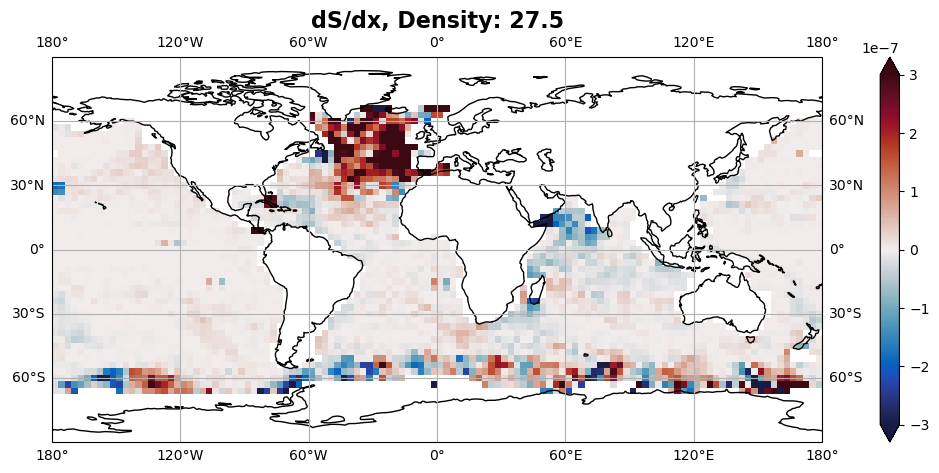

In [58]:
density = 27.5

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
sa_m_dx.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.balance, vmin=-3e-7, vmax=3e-7)
ax.set_title('dS/dx, Density: {}'.format(np.round(term3.sel(density=density, method='nearest').density.values, 1)))
plt.savefig('../notebooks/argo_clim/figs/dSdx_275.png', bbox_inches='tight')

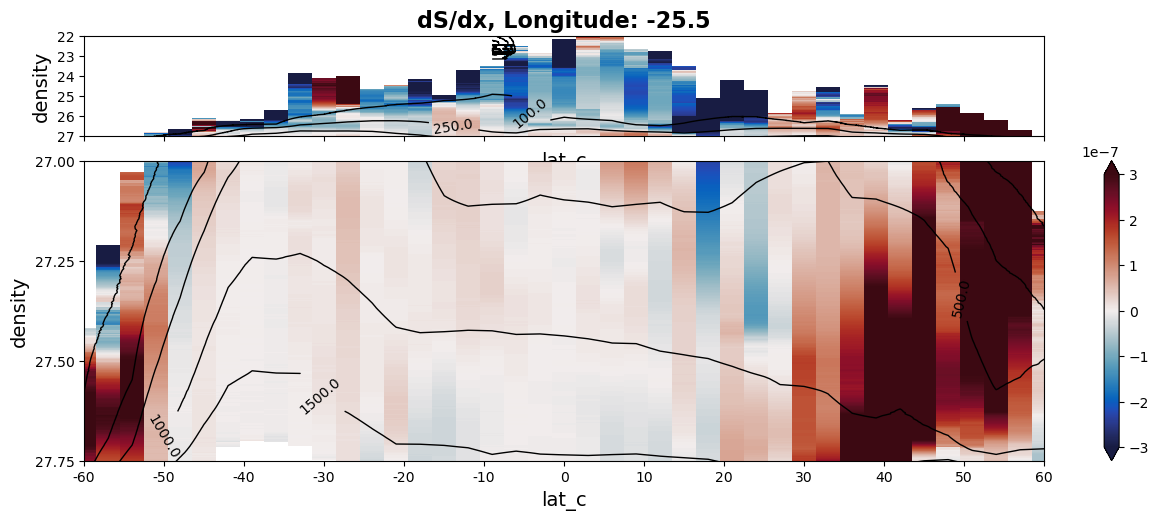

In [60]:
lon = -25

fig = plt.figure(figsize=(15, 5))
top_ax = fig.add_axes([0.1, 0.75, 0.64, 0.2])   # top subplot (1/4 of height)
bottom_ax = fig.add_axes([0.1, 0.1, 0.8, 0.6]) # bottom subplot (3/4 of height)

levels = [100, 250, 500, 1000, 1500, 2000]

sa_m_dx.sel(lon=lon, method='nearest').plot(ax=top_ax, x='lat', y='density', cmap=cmo.balance, vmin=-3e-7, vmax=3e-7, add_colorbar=False)
top_ax.set_xticks(np.arange(-70, 71, 10))
top_ax.set_xticklabels([''] * len(top_ax.get_xticks()))
top_ax.set_yticks(np.arange(27.0, 21.5, -1.0))
top_ax.set_xlabel('')
top_ax.set_ylim(27, 22)
top_ax.set_xlim(-60, 60)
contour = ds_rho.PRES.sel(lon_c=lon, method='nearest').plot.contour(ax=top_ax, x='lat_c', y='density', levels=levels, colors='k', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='k', fontsize=10)
top_ax.invert_yaxis()
top_ax.set_title(f'dS/dx, Longitude: {K_rho.sel(lon=lon, method="nearest").lon.values}')

sa_m_dx.sel(lon=lon, method='nearest').plot(ax=bottom_ax, x='lat', y='density', cmap=cmo.balance, vmin=-3e-7, vmax=3e-7)
bottom_ax.set_xticks(np.arange(-70, 71, 10))
bottom_ax.set_xticklabels(np.arange(-70, 71, 10))
bottom_ax.set_yticks(np.arange(27.75, 25.5, -0.25))
bottom_ax.set_ylim(27.75, 27)
bottom_ax.set_xlim(-60, 60)
contour = ds_rho.PRES.sel(lon_c=lon, method='nearest').plot.contour(ax=bottom_ax, x='lat_c', y='density', levels=levels, colors='k', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='k', fontsize=10)
bottom_ax.invert_yaxis()
bottom_ax.set_title('')

plt.savefig('../notebooks/argo_clim/figs/dSdx_275_sect.png', bbox_inches='tight')

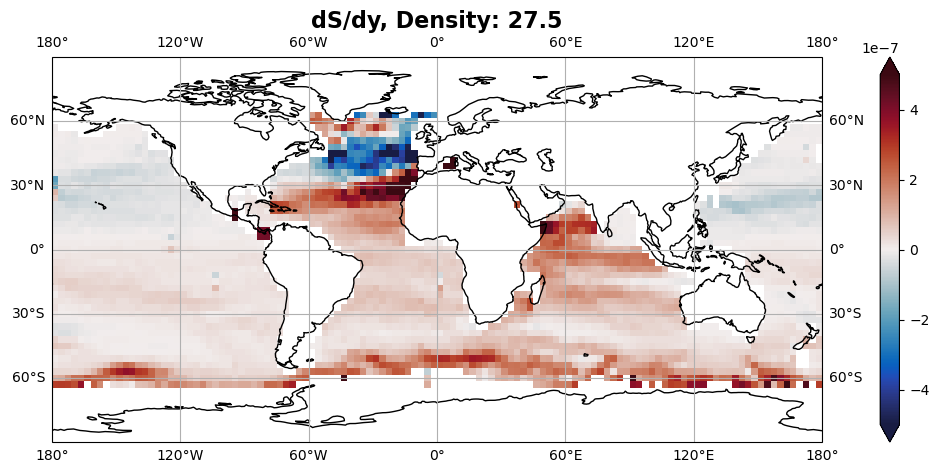

In [64]:
density = 27.5

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
sa_m_dy.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.balance, vmin=-5e-7, vmax=5e-7)
ax.set_title('dS/dy, Density: {}'.format(np.round(term3.sel(density=density, method='nearest').density.values, 1)))
plt.savefig('../notebooks/argo_clim/figs/dSdy_275.png', bbox_inches='tight')

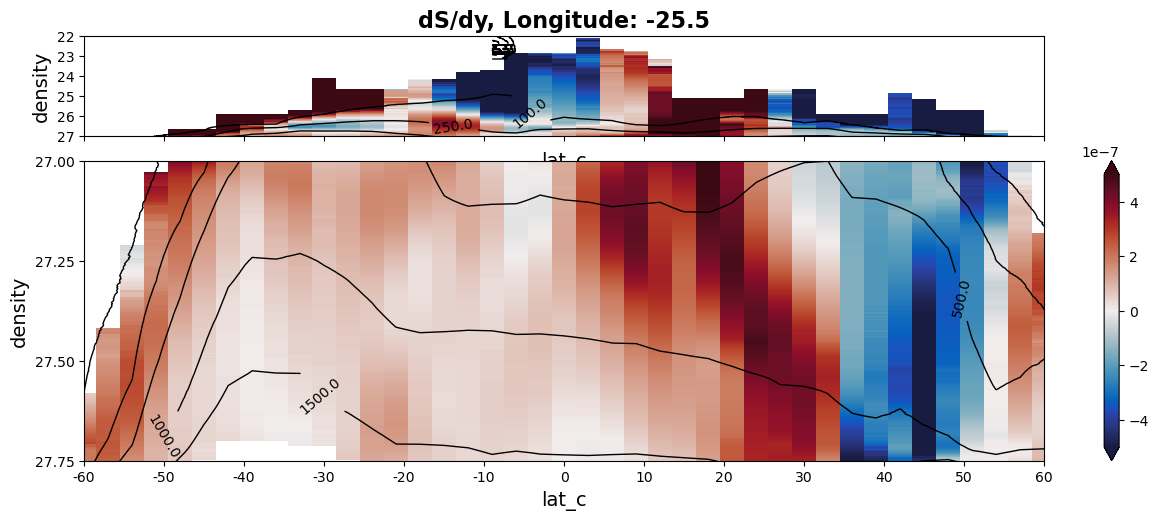

In [66]:
lon = -25

fig = plt.figure(figsize=(15, 5))
top_ax = fig.add_axes([0.1, 0.75, 0.64, 0.2])   # top subplot (1/4 of height)
bottom_ax = fig.add_axes([0.1, 0.1, 0.8, 0.6]) # bottom subplot (3/4 of height)

levels = [100, 250, 500, 1000, 1500, 2000]

sa_m_dy.sel(lon=lon, method='nearest').plot(ax=top_ax, x='lat', y='density', cmap=cmo.balance, vmin=-5e-7, vmax=5e-7, add_colorbar=False)
top_ax.set_xticks(np.arange(-70, 71, 10))
top_ax.set_xticklabels([''] * len(top_ax.get_xticks()))
top_ax.set_yticks(np.arange(27.0, 21.5, -1.0))
top_ax.set_xlabel('')
top_ax.set_ylim(27, 22)
top_ax.set_xlim(-60, 60)
contour = ds_rho.PRES.sel(lon_c=lon, method='nearest').plot.contour(ax=top_ax, x='lat_c', y='density', levels=levels, colors='k', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='k', fontsize=10)
top_ax.invert_yaxis()
top_ax.set_title(f'dS/dy, Longitude: {K_rho.sel(lon=lon, method="nearest").lon.values}')

sa_m_dy.sel(lon=lon, method='nearest').plot(ax=bottom_ax, x='lat', y='density', cmap=cmo.balance, vmin=-5e-7, vmax=5e-7)
bottom_ax.set_xticks(np.arange(-70, 71, 10))
bottom_ax.set_xticklabels(np.arange(-70, 71, 10))
bottom_ax.set_yticks(np.arange(27.75, 25.5, -0.25))
bottom_ax.set_ylim(27.75, 27)
bottom_ax.set_xlim(-60, 60)
contour = ds_rho.PRES.sel(lon_c=lon, method='nearest').plot.contour(ax=bottom_ax, x='lat_c', y='density', levels=levels, colors='k', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='k', fontsize=10)
bottom_ax.invert_yaxis()
bottom_ax.set_title('')

plt.savefig('../notebooks/argo_clim/figs/dSdy_275_sect.png', bbox_inches='tight')

In [76]:
dS_dx = sa_m_dx.rename('dS_dx')
dS_dy = sa_m_dy.rename('dS_dy')

In [77]:
# Choose a density slice—here using index, but you could use `.sel(density=...)` too
k = 27.5  # example index for a specific density level
u = dS_dx.sel(density=k, method='nearest')
v = dS_dy.sel(density=k, method='nearest')

# Create meshgrid from coordinates for plotting
X, Y = u['lon'], u['lat']
XX, YY = np.meshgrid(X, Y, indexing='ij')  # match xarray's dimension order

# Transpose u and v to match meshgrid shape (lon x lat)
U = u.transpose('lon', 'lat').values
V = v.transpose('lon', 'lat').values

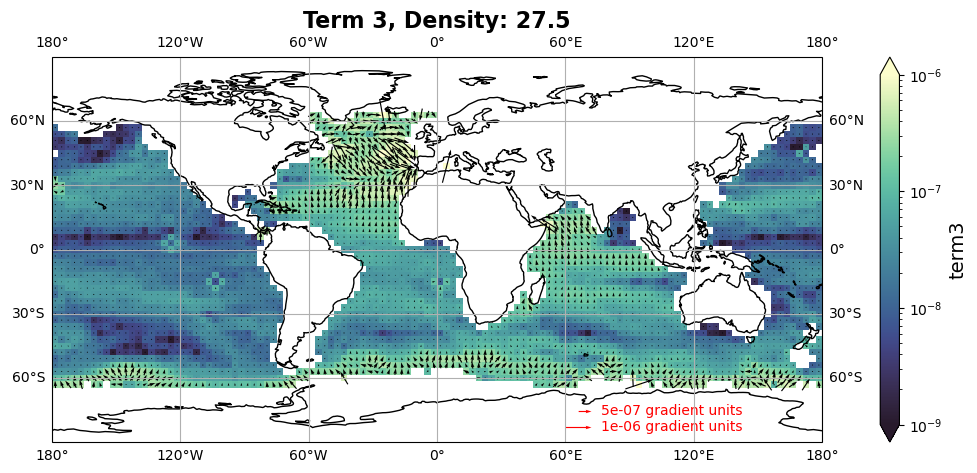

In [102]:
density = 27.5

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
term3.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.deep_r, norm=colors.LogNorm(vmin=1e-9, vmax=1e-6))
q = ax.quiver(XX, YY, U, V, scale=3e-5, pivot='middle', width=0.0015)
ax.quiverkey(q, X=0.7, Y=0.08, U=5e-7, label=f'{5e-7:.0e} gradient units', labelpos='E',color='r',labelcolor='r')
ax.quiverkey(q, X=0.7, Y=0.04, U=1e-6, label=f'{1e-6:.0e} gradient units', labelpos='E',color='r',labelcolor='r')
ax.set_title('Term 3, Density: {}'.format(np.round(term3.sel(density=density, method='nearest').density.values, 1)))
plt.savefig('../notebooks/argo_clim/figs/term3_sa_275.png', bbox_inches='tight')

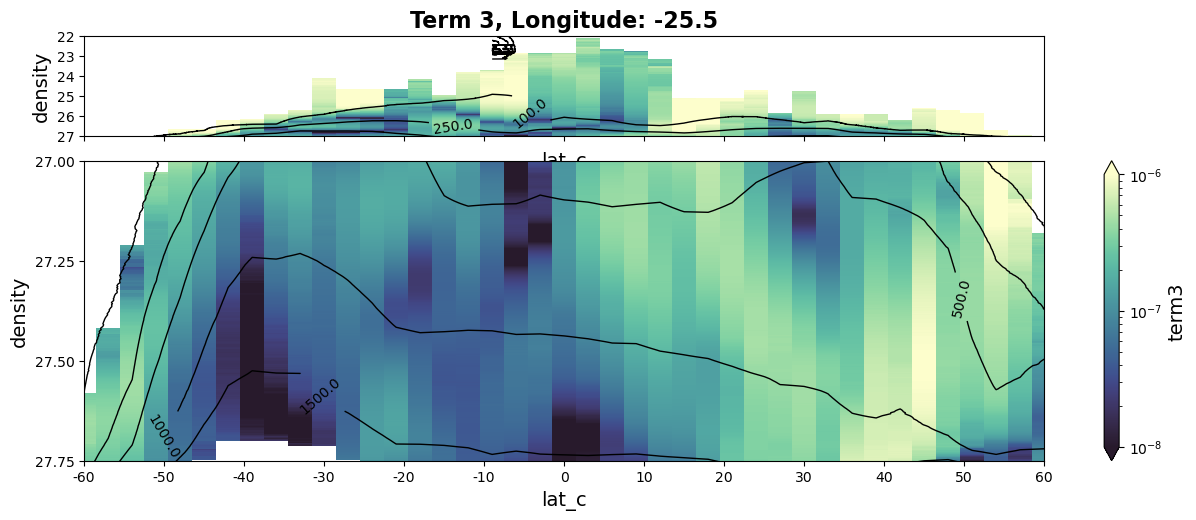

In [70]:
lon = -25

fig = plt.figure(figsize=(15, 5))
top_ax = fig.add_axes([0.1, 0.75, 0.64, 0.2])   # top subplot (1/4 of height)
bottom_ax = fig.add_axes([0.1, 0.1, 0.8, 0.6]) # bottom subplot (3/4 of height)

norm = colors.LogNorm(vmin=1e-8, vmax=1e-6)
levels = [100, 250, 500, 1000, 1500, 2000]

term3.sel(lon=lon, method='nearest').plot(ax=top_ax, x='lat', y='density', cmap=cmo.deep_r, norm=norm, add_colorbar=False)
top_ax.set_xticks(np.arange(-70, 71, 10))
top_ax.set_xticklabels([''] * len(top_ax.get_xticks()))
top_ax.set_yticks(np.arange(27.0, 21.5, -1.0))
top_ax.set_xlabel('')
top_ax.set_ylim(27, 22)
top_ax.set_xlim(-60, 60)
contour = ds_rho.PRES.sel(lon_c=lon, method='nearest').plot.contour(ax=top_ax, x='lat_c', y='density', levels=levels, colors='k', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='k', fontsize=10)
top_ax.invert_yaxis()
top_ax.set_title(f'Term 3, Longitude: {K_rho.sel(lon=lon, method="nearest").lon.values}')

term3.sel(lon=lon, method='nearest').plot(ax=bottom_ax, x='lat', y='density', cmap=cmo.deep_r, norm=norm)
bottom_ax.set_xticks(np.arange(-70, 71, 10))
bottom_ax.set_xticklabels(np.arange(-70, 71, 10))
bottom_ax.set_yticks(np.arange(27.75, 25.5, -0.25))
bottom_ax.set_ylim(27.75, 27)
bottom_ax.set_xlim(-60, 60)
contour = ds_rho.PRES.sel(lon_c=lon, method='nearest').plot.contour(ax=bottom_ax, x='lat_c', y='density', levels=levels, colors='k', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='k', fontsize=10)
bottom_ax.invert_yaxis()
bottom_ax.set_title('')

plt.savefig('../notebooks/argo_clim/figs/term3_sa_275_sect.png', bbox_inches='tight')

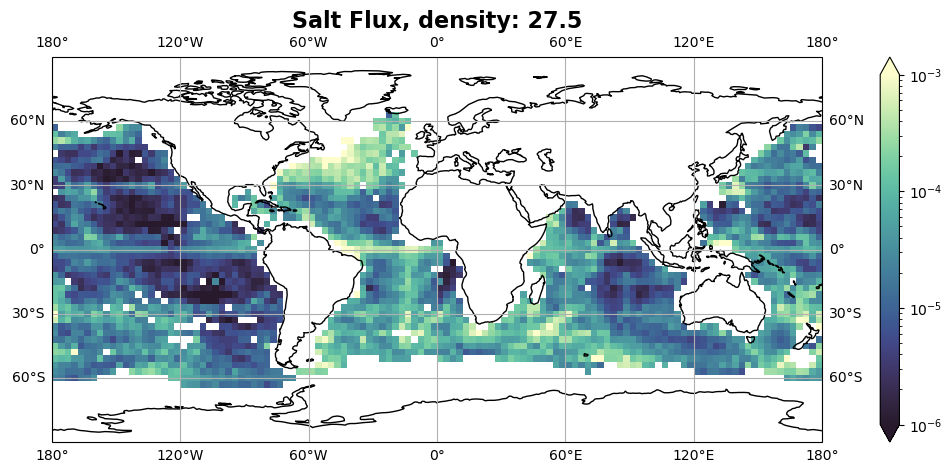

In [73]:
density = 27.5

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
salt_flux_dxdy.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.deep_r, norm=colors.LogNorm(vmin=1e-6, vmax=1e-3))
plt.title('Salt Flux, density: {}'.format(np.round(salt_flux_dxdy.sel(density=density, method='nearest').density.values, 1)))
plt.savefig('../notebooks/argo_clim/figs/salt_flux_275.png', bbox_inches='tight')

Text(0.5, 1.0, 'K_e from salt, density: 26.5')

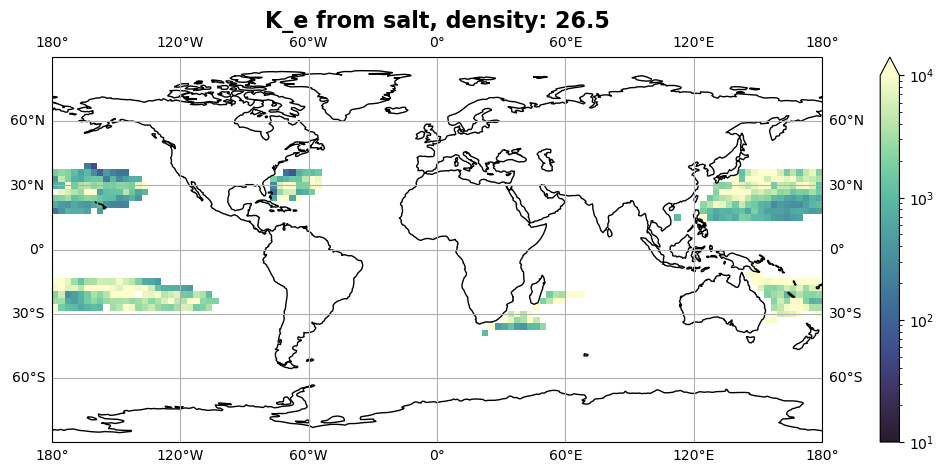

In [109]:
density = 26.5

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
K_e_salt.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.deep_r, norm=colors.LogNorm(vmin=1e1, vmax=1e4))
plt.title('K_e from salt, density: {}'.format(np.round(salt_flux_dxdy.sel(density=density, method='nearest').density.values, 1)))
#plt.savefig('../notebooks/argo_clim/figs/salt_flux_275.png', bbox_inches='tight')

In [106]:
K_e = K_e_salt

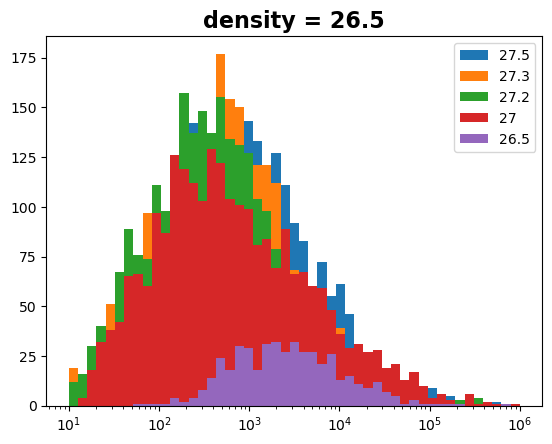

In [108]:
K_e.sel(density=27.5, method='nearest').plot.hist(bins=np.logspace(1,6,50),label=27.5)
K_e.sel(density=27.3, method='nearest').plot.hist(bins=np.logspace(1,6,50),label=27.3)
K_e.sel(density=27.2, method='nearest').plot.hist(bins=np.logspace(1,6,50),label=27.2)
K_e.sel(density=27, method='nearest').plot.hist(bins=np.logspace(1,6,50),label=27)
K_e.sel(density=26.5, method='nearest').plot.hist(bins=np.logspace(1,6,50),label=26.5)
plt.legend()
plt.xscale('log');

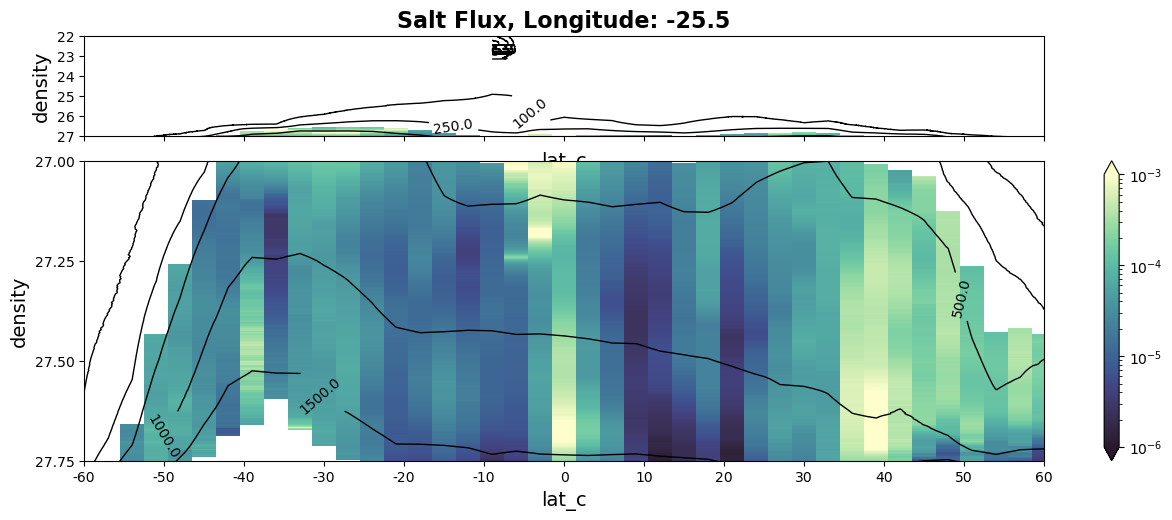

In [74]:
lon = -25

fig = plt.figure(figsize=(15, 5))
top_ax = fig.add_axes([0.1, 0.75, 0.64, 0.2])   # top subplot (1/4 of height)
bottom_ax = fig.add_axes([0.1, 0.1, 0.8, 0.6]) # bottom subplot (3/4 of height)

norm = colors.LogNorm(vmin=1e-6, vmax=1e-3)
levels = [100, 250, 500, 1000, 1500, 2000]

salt_flux_dxdy.sel(lon=lon, method='nearest').plot(ax=top_ax, x='lat', y='density', cmap=cmo.deep_r, norm=norm, add_colorbar=False)
top_ax.set_xticks(np.arange(-70, 71, 10))
top_ax.set_xticklabels([''] * len(top_ax.get_xticks()))
top_ax.set_yticks(np.arange(27.0, 21.5, -1.0))
top_ax.set_xlabel('')
top_ax.set_ylim(27, 22)
top_ax.set_xlim(-60, 60)
contour = ds_rho.PRES.sel(lon_c=lon, method='nearest').plot.contour(ax=top_ax, x='lat_c', y='density', levels=levels, colors='k', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='k', fontsize=10)
top_ax.invert_yaxis()
top_ax.set_title(f'Salt Flux, Longitude: {K_rho.sel(lon=lon, method="nearest").lon.values}')

salt_flux_dxdy.sel(lon=lon, method='nearest').plot(ax=bottom_ax, x='lat', y='density', cmap=cmo.deep_r, norm=norm)
bottom_ax.set_xticks(np.arange(-70, 71, 10))
bottom_ax.set_xticklabels(np.arange(-70, 71, 10))
bottom_ax.set_yticks(np.arange(27.75, 25.5, -0.25))
bottom_ax.set_ylim(27.75, 27)
bottom_ax.set_xlim(-60, 60)
contour = ds_rho.PRES.sel(lon_c=lon, method='nearest').plot.contour(ax=bottom_ax, x='lat_c', y='density', levels=levels, colors='k', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='k', fontsize=10)
bottom_ax.invert_yaxis()
bottom_ax.set_title('')

plt.savefig('../notebooks/argo_clim/figs/salt_flux_275_sect.png', bbox_inches='tight')